# Creation of animated visualizations of the KmerGMA method

In [4]:
using Plots, KmerGMA
using BioSequences, FASTX, Distances, Random, BioAlignments

In [72]:
using BioSequences, FASTX, Distances, BioAlignments

const InputConstant = NamedTuple{(:genome, :refVec, :consensus_refseq, :k, :windowsize, :thr, :mask, :Nt_bits, :ScaleFactor), Tuple{LongSequence{DNAAlphabet{4}}, Vector{Float64}, LongSequence{DNAAlphabet{4}}, Int64, Int64, Int64, UInt64, Dict{DNA, UInt64}, Float64}}

RV, ws, cons = gen_ref_ws_cons("Sequences/88_Alpaca_reference_V_genes.fasta", 6)

function init_InputConstant(;
    genome::Seq = randdnaseq(100)*cons[1:50]*randdnaseq(340)*cons*randdnaseq(300),
    refVec::Vector{Float64} = RV,
    consensus_refseq::Seq = cons,
    k::Int64 = 6,
    windowsize::Int64 = ws,
    thr::Union{Int64, Float64} = 25,
    mask::UInt64 = unsigned(4095), 
    Nt_bits::DnaBits = NUCLEOTIDE_BITS,
    ScaleFactor::Float64 = 0.0833333333333333333333
    )
    return (genome = genome,refVec = refVec,consensus_refseq = consensus_refseq,
        k = k,windowsize = windowsize,thr = thr,mask = mask,Nt_bits = Nt_bits,ScaleFactor=ScaleFactor)
end

function gma_plot(; inp::InputConstant = init_InputConstant(),
    curr_kmer_freq::Vector{Float64} = zeros(4096),
    dist_vec = Float64[], 
    genome_pos::Int = 0
    )
    a = Animation()

    k = inp.k
    seq::Seq = inp.genome
    proceed::Bool, goal_ind::Int64= true, 0

    #edge case
    sequence_length = length(seq)
    if sequence_length < inp.windowsize; return end

    KmerGMA.kmer_count!(str = view(seq, 1:inp.windowsize), k = k,
        bins = curr_kmer_freq, mask = inp.mask, Nt_bits = inp.Nt_bits)
    currSqrEuc = Distances.sqeuclidean(inp.refVec, curr_kmer_freq)
    
    #initializing variables
    CMI, stop, currminim = 2, true, currSqrEuc

    left_kmer = unsigned(0)
    for c in seq[1:k-1]
        left_kmer = (left_kmer << 2) + inp.Nt_bits[c]
    end

    right_kmer = unsigned(0)
    for c in seq[inp.windowsize-k+1:inp.windowsize-1]
        right_kmer = (right_kmer << 2) + inp.Nt_bits[c]
    end

    #l = @layout([a{0.6w} [b{0.5h}; c{0.5h}]])
    l = (3,1)

    for i in 1:length(seq)-inp.windowsize
        # first kmer
        left_kmer = ((left_kmer << 2) & inp.mask) + inp.Nt_bits[seq[i+k-1]]
        left_ind = -~left_kmer
        @views currSqrEuc -= (inp.refVec[left_ind]-curr_kmer_freq[left_ind])^2 
        curr_kmer_freq[left_ind] -= 1
        @views currSqrEuc += (inp.refVec[left_ind]-curr_kmer_freq[left_ind])^2

        # last kmer + 1bp
        right_kmer = ((right_kmer << 2) & inp.mask) + inp.Nt_bits[seq[i+inp.windowsize-1]]
        right_ind = -~right_kmer
        @views currSqrEuc -= (inp.refVec[right_ind]-curr_kmer_freq[right_ind])^2
        curr_kmer_freq[right_ind] += 1
        @views currSqrEuc += (inp.refVec[right_ind]-curr_kmer_freq[right_ind])^2

        # convert to kmer Distance 
        kmerDist = currSqrEuc * inp.ScaleFactor 
        push!(dist_vec, kmerDist)

        if i > 400
            popfirst!(dist_vec)
            dist_plot = plot(dist_vec, xlabel = "position along genome", ylabel = "Distance", xaxis=false, color ="#9358A4", label = nothing, title = "Kmer Distance across the genome", ylims = (4.5,42))
            plot!([1,length(dist_vec)*1.3],[inp.thr,inp.thr], label = nothing, color = "#399746")
            
            rd = round(kmerDist, digits = 2)
            curr_KFV_plot = plot(RV, label = "Reference", ylabel = "Count", xlabel = "Kmers", color = "#4C64B0", legend=:topleft) #thickness_scaling = 0.5, ylims = (0,3), title = "Reference Kmer Frequency (pre-generated)"
            plot!(curr_kmer_freq, thickness_scaling = 0.5, label = "Current", title = "Current Kmer Frequency | distance = $rd", ylabel = "Count", xlabel = "Kmers", color = "#CB392E", ylims = (0,3), alpha = 0.4)
            frame(a, plot(dist_plot, curr_KFV_plot, layout = (2,1)))#RV_plot, 
        end
    end
    return a
end


gma_plot (generic function with 1 method)

┌ Info: Saved animation to C:\Users\lu_41\AppData\Local\Temp\jl_WBvghsGoC5.gif
└ @ Plots C:\Users\lu_41\.julia\packages\Plots\9Q9pN\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\lu_41\\AppData\\Local\\Temp\\jl_WBvghsGoC5.gif")
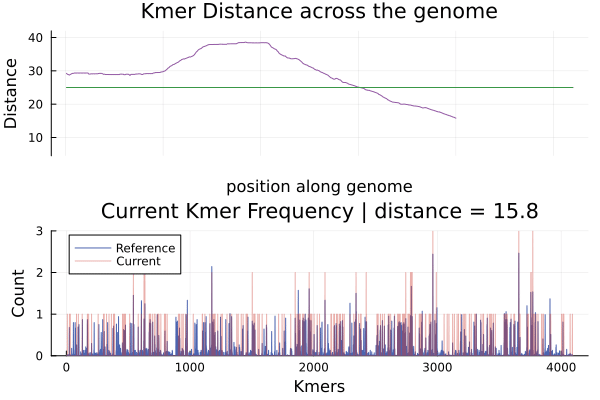

In [74]:
gif(gma_plot(), fps = 60)

### Animation of kmer counting
___

In [95]:
function count_kmer_plot()
    a = Animation()
    str = cons[1:100]
    k::Int, Nt_bits::DnaBits = 3, NUCLEOTIDE_BITS
    bins, mask, kmer = zeros(4^k), unsigned((4^k)-1), unsigned(0)
    for c in view(str, 1:k-1)
        kmer = (kmer << 2) + Nt_bits[c]
    end
    for (i, c) in enumerate(view(str, k:length(str)))
        kmer = ((kmer << 2) & mask) + Nt_bits[c]
        bins[kmer + 1] += 1
        currkmer = "["*uppercase(string(as_kmer(kmer, k)))*"]"
        seq = lowercase(string(str[1:i-k]))*currkmer*lowercase(string(str[i+1:end]))
        seq = "Kmer counting (k = 3)\n"*seq[1:48]*"\n"*seq[49:100]#*"\n"*seq[151:225]*"\n"*seq[226:end]*"\n"
        #seq = seq[1:50]*"\n"*seq[51:100]*"\n"*seq[101:150]*"\n"*seq[151:200]*"\n"*seq[201:250]*"\n"*seq[251:end]
        frame(a, bar(bins, ylims = (0,8), label = nothing, ylabel = "Count", xlabel = "Kmers", title = "$seq", xaxis=nothing, titlefontsize=9)) #
    end
    return a
end

count_kmer_plot (generic function with 1 method)

┌ Info: Saved animation to C:\Users\lu_41\AppData\Local\Temp\jl_uDjaxDu314.gif
└ @ Plots C:\Users\lu_41\.julia\packages\Plots\9Q9pN\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\lu_41\\AppData\\Local\\Temp\\jl_uDjaxDu314.gif")
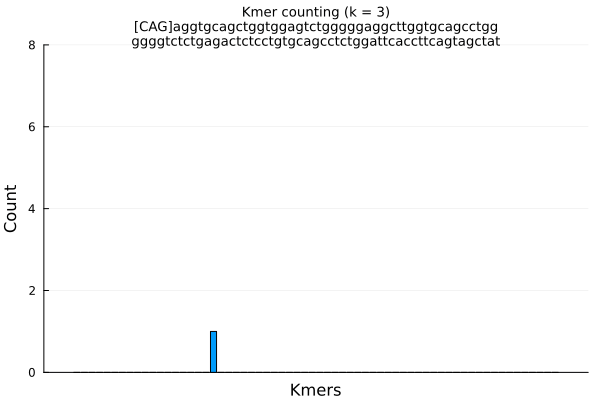

In [96]:
gif(count_kmer_plot())